# Traditional Data Science Analysis

This notebook performs traditional data science analysis on GitHub activity data:

**Statistical Analysis:**
- Distributions, correlations, trends

**Visualizations (6+):**
1. Commit frequency over time
2. Language distribution
3. Activity heatmap (day of week × hour)
4. Repository comparison
5. Commit message length analysis
6. Contribution timeline

**ML Techniques (2):**
1. K-Means clustering of commits
2. Time series forecasting of activity

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from datetime import datetime
from collections import Counter

# ML imports
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

DATA = Path("..") / "data"
OUT = Path("..") / "outputs"

In [2]:
# Load all data
commits = pd.read_csv(DATA / "commits.csv")
repos = pd.read_csv(DATA / "repos.csv")
languages = pd.read_csv(DATA / "languages.csv")
events = pd.read_csv(DATA / "events.csv")

# Parse dates and convert to Central Time
commits["date"] = pd.to_datetime(commits["date"]).dt.tz_convert("America/Chicago")
repos["created_at"] = pd.to_datetime(repos["created_at"])
repos["updated_at"] = pd.to_datetime(repos["updated_at"])
events["created_at"] = pd.to_datetime(events["created_at"])

print(f"Commits: {len(commits)}")
print(f"Repos: {len(repos)}")
print(f"Languages: {len(languages)}")
print(f"Events: {len(events)}")
print(f"\\nCommit times displayed in: Central Time (America/Chicago)")

Commits: 23
Repos: 7
Languages: 17
Events: 32
\nCommit times displayed in: Central Time (America/Chicago)


---
## Part 1: Statistical Analysis

In [3]:
# Commit statistics
commits["msg_length"] = commits["message"].fillna("").str.len()
commits["word_count"] = commits["message"].fillna("").str.split().str.len()
commits["hour"] = commits["date"].dt.hour
commits["day_of_week"] = commits["date"].dt.dayofweek
commits["month"] = commits["date"].dt.to_period('M')

print("="*60)
print("COMMIT MESSAGE STATISTICS")
print("="*60)
print(f"\nTotal commits: {len(commits)}")
print(f"\nMessage length (characters):")
print(commits["msg_length"].describe().round(2))
print(f"\nWord count:")
print(commits["word_count"].describe().round(2))

COMMIT MESSAGE STATISTICS

Total commits: 23

Message length (characters):
count     23.00
mean      78.13
std      119.83
min        3.00
25%       12.50
50%       19.00
75%       52.50
max      368.00
Name: msg_length, dtype: float64

Word count:
count    23.00
mean     10.87
std      16.26
min       1.00
25%       2.00
50%       3.00
75%       8.00
max      51.00
Name: word_count, dtype: float64


/var/folders/0b/4q6tccn90zd2mrdvjhd77ydm0000gn/T/ipykernel_41989/1694646454.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  commits["month"] = commits["date"].dt.to_period('M')


In [4]:
# Repository statistics
print("="*60)
print("REPOSITORY STATISTICS")
print("="*60)
print(f"\nTotal repositories: {len(repos)}")
print(f"Forked repos: {repos['is_fork'].sum()}")
print(f"Original repos: {(~repos['is_fork']).sum()}")
print(f"\nRepository sizes (KB):")
print(repos["size_kb"].describe().round(2))
print(f"\nTotal code size: {repos['size_kb'].sum():,.0f} KB ({repos['size_kb'].sum()/1024:.1f} MB)")

REPOSITORY STATISTICS

Total repositories: 7
Forked repos: 2
Original repos: 5

Repository sizes (KB):
count         7.00
mean      21464.43
std       55213.38
min           6.00
25%         141.00
50%         271.00
75%        1517.00
max      146658.00
Name: size_kb, dtype: float64

Total code size: 150,251 KB (146.7 MB)


In [5]:
# Activity patterns
print("="*60)
print("ACTIVITY PATTERNS")
print("="*60)

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
commits_by_day = commits["day_of_week"].value_counts().sort_index()
print("\nCommits by day of week:")
for day_num, count in commits_by_day.items():
    print(f"  {day_names[day_num]}: {count} ({count/len(commits)*100:.1f}%)")

print(f"\nMost active hour: {commits['hour'].mode().iloc[0]}:00 Central Time")
print(f"Date range: {commits['date'].min().strftime('%Y-%m-%d')} to {commits['date'].max().strftime('%Y-%m-%d')}")

# Calculate activity span
activity_span = (commits['date'].max() - commits['date'].min()).days
print(f"Activity span: {activity_span} days")
print(f"Average commits per month: {len(commits) / max(1, activity_span/30):.1f}")

ACTIVITY PATTERNS

Commits by day of week:
  Monday: 2 (8.7%)
  Tuesday: 5 (21.7%)
  Thursday: 5 (21.7%)
  Friday: 2 (8.7%)
  Saturday: 4 (17.4%)
  Sunday: 5 (21.7%)

Most active hour: 16:00 Central Time
Date range: 2023-10-29 to 2026-02-10
Activity span: 835 days
Average commits per month: 0.8


In [6]:
# Language distribution
print("="*60)
print("LANGUAGE STATISTICS")
print("="*60)

lang_totals = languages.groupby("language")["bytes"].sum().sort_values(ascending=False)
total_bytes = lang_totals.sum()

print("\nLanguage distribution (by bytes):")
for lang, bytes_count in lang_totals.head(10).items():
    pct = bytes_count / total_bytes * 100
    print(f"  {lang}: {bytes_count:,} bytes ({pct:.1f}%)")

LANGUAGE STATISTICS

Language distribution (by bytes):
  Rust: 14,696,979 bytes (62.6%)
  Python: 8,604,071 bytes (36.7%)
  Jupyter Notebook: 110,975 bytes (0.5%)
  Nix: 19,687 bytes (0.1%)
  Makefile: 18,211 bytes (0.1%)
  JavaScript: 14,968 bytes (0.1%)
  CSS: 3,343 bytes (0.0%)
  HTML: 1,535 bytes (0.0%)
  RenderScript: 1 bytes (0.0%)


---
## Part 2: Visualizations (6+)

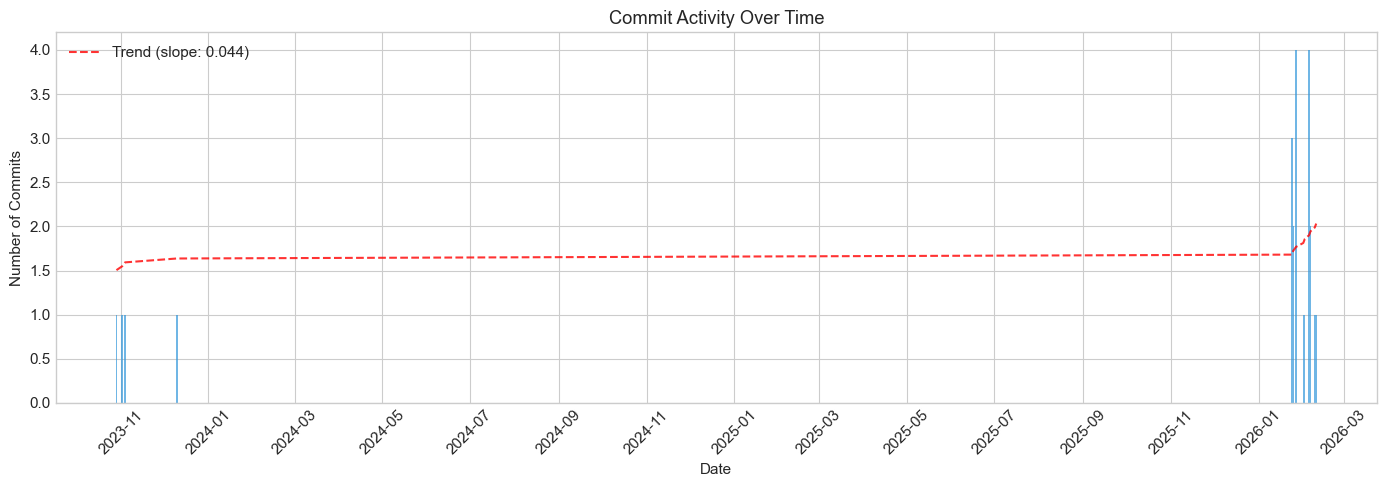

In [7]:
# VISUALIZATION 1: Commit Timeline
fig, ax = plt.subplots(figsize=(14, 5))

# Group by date
daily_commits = commits.groupby(commits["date"].dt.date).size()

ax.bar(daily_commits.index, daily_commits.values, color='#3498db', alpha=0.7, width=1)
ax.set_xlabel("Date")
ax.set_ylabel("Number of Commits")
ax.set_title("Commit Activity Over Time")

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

# Add trend line
if len(daily_commits) > 1:
    x_numeric = np.arange(len(daily_commits))
    z = np.polyfit(x_numeric, daily_commits.values, 1)
    p = np.poly1d(z)
    ax.plot(daily_commits.index, p(x_numeric), "r--", alpha=0.8, label=f"Trend (slope: {z[0]:.3f})")
    ax.legend()

plt.tight_layout()
plt.savefig("../outputs/viz1_commit_timeline.png", dpi=150)
plt.show()

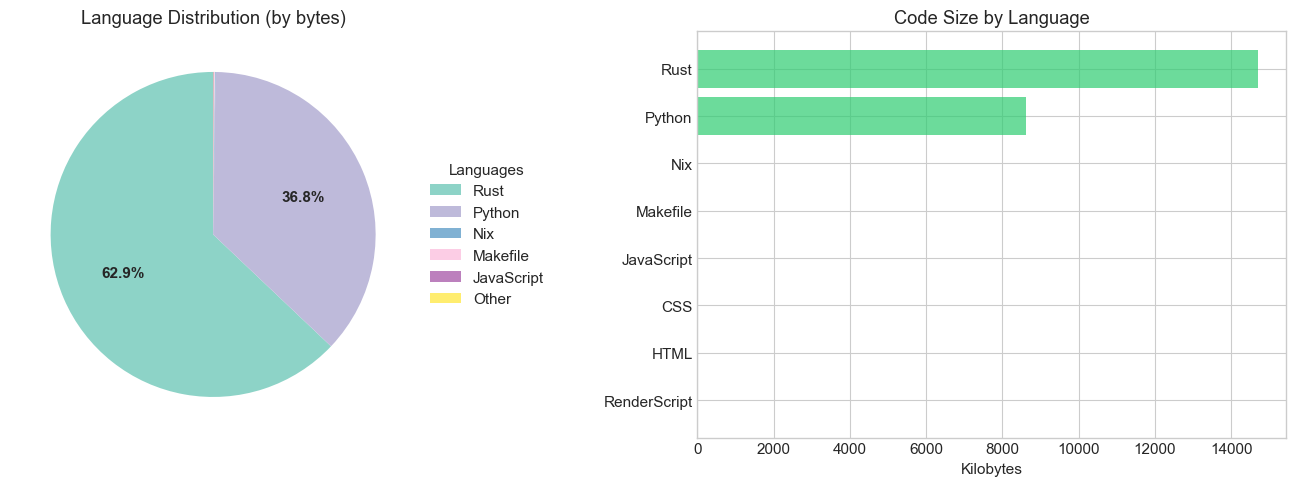

In [8]:
# VISUALIZATION 2: Language Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter out "Jupyter Notebook" - it's a file format, not a language
lang_totals_filtered = lang_totals.drop("Jupyter Notebook", errors="ignore")

# Pie chart (top 5 + other)
top_5 = lang_totals_filtered.head(5)
other = lang_totals_filtered.iloc[5:].sum()
pie_data = pd.concat([top_5, pd.Series({'Other': other})])

colors = plt.cm.Set3(np.linspace(0, 1, len(pie_data)))

# Only show percentage labels for slices > 5%
def autopct_func(pct):
    return f'{pct:.1f}%' if pct > 5 else ''

wedges, texts, autotexts = axes[0].pie(
    pie_data, 
    labels=None,  # No labels on the pie itself
    autopct=autopct_func,
    colors=colors, 
    startangle=90,
    pctdistance=0.6
)

# Make percentage text bold and larger
for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

# Add legend on the side
axes[0].legend(wedges, pie_data.index, title="Languages", loc="center left", bbox_to_anchor=(1, 0.5))
axes[0].set_title("Language Distribution (by bytes)")

# Bar chart (all languages) - also filter out Jupyter Notebook
bars = axes[1].barh(lang_totals_filtered.index[::-1], lang_totals_filtered.values[::-1] / 1000, color='#2ecc71', alpha=0.7)
axes[1].set_xlabel("Kilobytes")
axes[1].set_title("Code Size by Language")

plt.tight_layout()
plt.savefig("../outputs/viz2_languages.png", dpi=150, bbox_inches='tight')
plt.show()

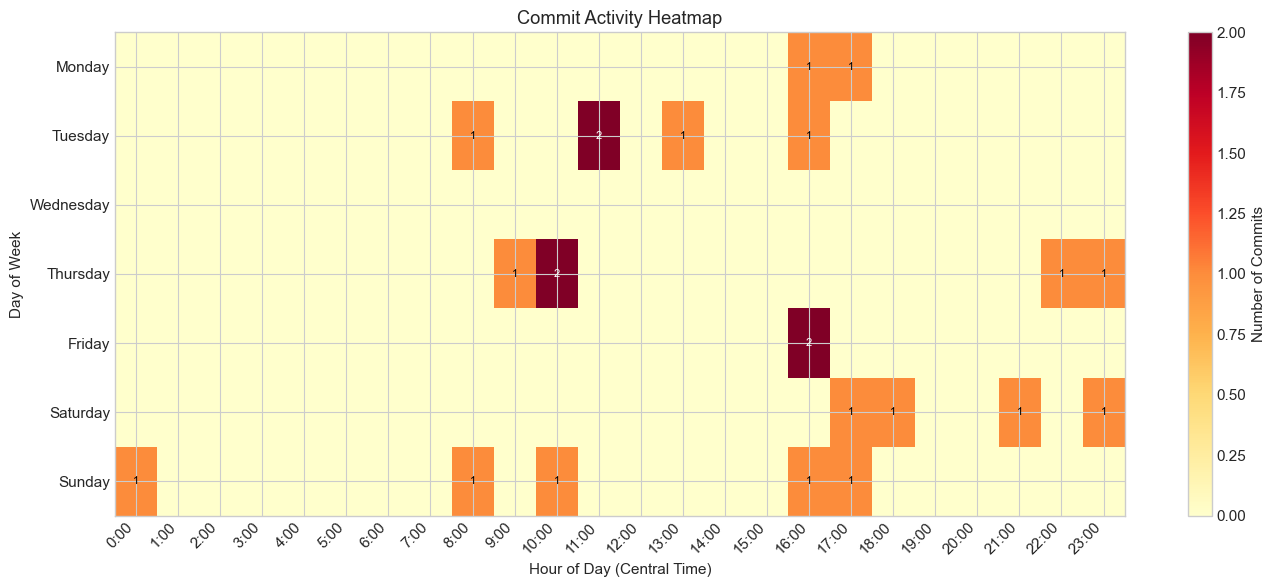

In [9]:
# VISUALIZATION 3: Activity Heatmap (Day × Hour)
fig, ax = plt.subplots(figsize=(14, 6))

# Create pivot table
heatmap_data = commits.groupby(["day_of_week", "hour"]).size().unstack(fill_value=0)

# Ensure all hours are present
for h in range(24):
    if h not in heatmap_data.columns:
        heatmap_data[h] = 0
heatmap_data = heatmap_data.reindex(columns=range(24), fill_value=0)
heatmap_data = heatmap_data.reindex(range(7), fill_value=0)

im = ax.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')

ax.set_xticks(range(24))
ax.set_xticklabels([f"{h}:00" for h in range(24)], rotation=45, ha='right')
ax.set_yticks(range(7))
ax.set_yticklabels(day_names)
ax.set_xlabel("Hour of Day (Central Time)")
ax.set_ylabel("Day of Week")
ax.set_title("Commit Activity Heatmap")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Number of Commits")

# Annotate cells with values
for i in range(7):
    for j in range(24):
        val = heatmap_data.values[i, j]
        if val > 0:
            ax.text(j, i, int(val), ha='center', va='center', fontsize=8,
                   color='white' if val > heatmap_data.values.max()/2 else 'black')

plt.tight_layout()
plt.savefig("../outputs/viz3_activity_heatmap.png", dpi=150)
plt.show()

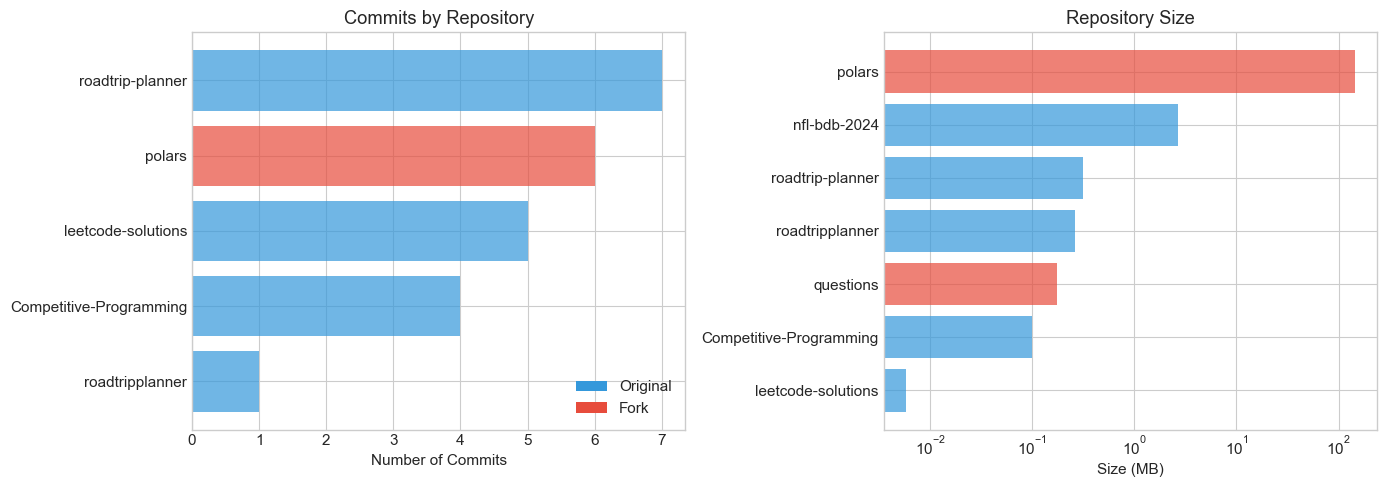

In [10]:
# VISUALIZATION 4: Repository Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Commits per repo
commits_per_repo = commits.groupby("repo_name").size().sort_values(ascending=True)
colors = ['#e74c3c' if repos[repos['repo_name']==r]['is_fork'].values[0] else '#3498db' 
          for r in commits_per_repo.index]
axes[0].barh(commits_per_repo.index, commits_per_repo.values, color=colors, alpha=0.7)
axes[0].set_xlabel("Number of Commits")
axes[0].set_title("Commits by Repository")
# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', label='Original'),
                   Patch(facecolor='#e74c3c', label='Fork')]
axes[0].legend(handles=legend_elements, loc='lower right')

# Repo size
repo_sizes = repos.set_index("repo_name")["size_kb"].sort_values(ascending=True)
colors = ['#e74c3c' if repos[repos['repo_name']==r]['is_fork'].values[0] else '#3498db' 
          for r in repo_sizes.index]
axes[1].barh(repo_sizes.index, repo_sizes.values / 1024, color=colors, alpha=0.7)
axes[1].set_xlabel("Size (MB)")
axes[1].set_title("Repository Size")
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig("../outputs/viz4_repo_comparison.png", dpi=150)
plt.show()

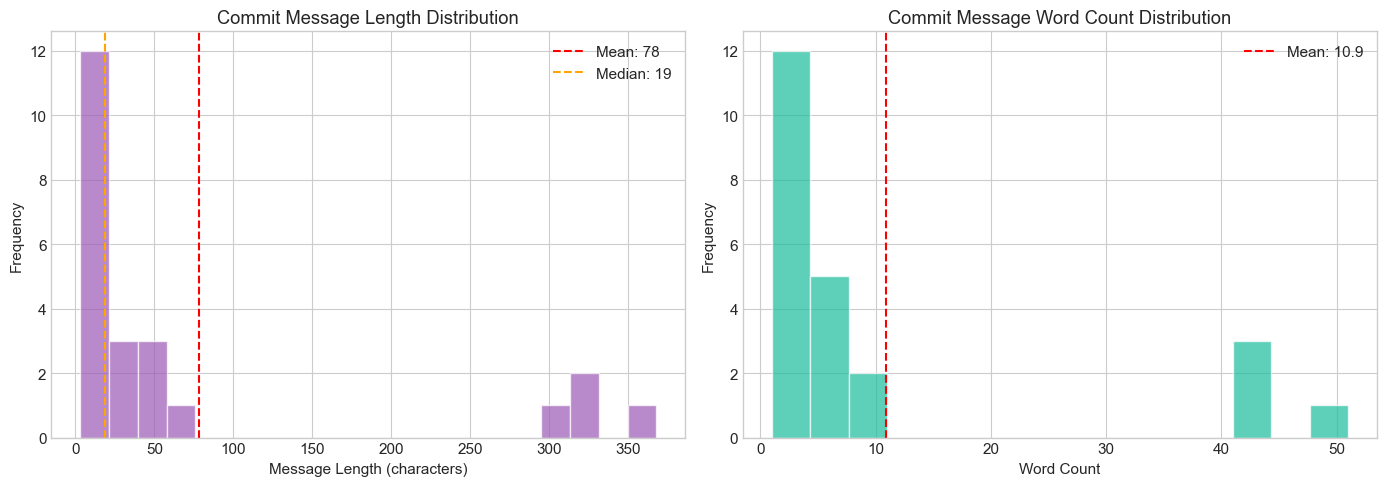

In [11]:
# VISUALIZATION 5: Commit Message Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Message length distribution
axes[0].hist(commits["msg_length"], bins=20, color='#9b59b6', alpha=0.7, edgecolor='white')
axes[0].axvline(commits["msg_length"].mean(), color='red', linestyle='--', label=f'Mean: {commits["msg_length"].mean():.0f}')
axes[0].axvline(commits["msg_length"].median(), color='orange', linestyle='--', label=f'Median: {commits["msg_length"].median():.0f}')
axes[0].set_xlabel("Message Length (characters)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Commit Message Length Distribution")
axes[0].legend()

# Word count distribution
axes[1].hist(commits["word_count"], bins=15, color='#1abc9c', alpha=0.7, edgecolor='white')
axes[1].axvline(commits["word_count"].mean(), color='red', linestyle='--', label=f'Mean: {commits["word_count"].mean():.1f}')
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Commit Message Word Count Distribution")
axes[1].legend()

plt.tight_layout()
plt.savefig("../outputs/viz5_message_analysis.png", dpi=150)
plt.show()

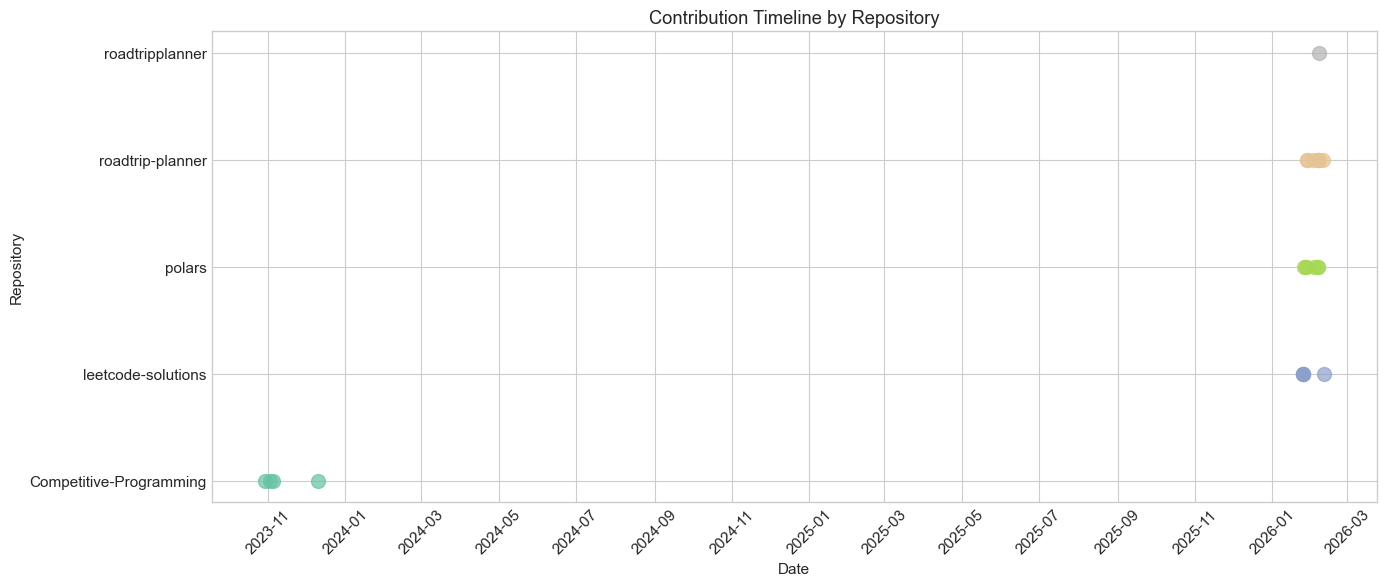

In [12]:
# VISUALIZATION 6: Contribution Timeline by Repository
fig, ax = plt.subplots(figsize=(14, 6))

repo_list = commits["repo_name"].unique()
colors = plt.cm.Set2(np.linspace(0, 1, len(repo_list)))

for i, repo in enumerate(repo_list):
    repo_commits = commits[commits["repo_name"] == repo]
    ax.scatter(repo_commits["date"], [i] * len(repo_commits), 
               label=repo, alpha=0.7, s=100, c=[colors[i]])

ax.set_yticks(range(len(repo_list)))
ax.set_yticklabels(repo_list)
ax.set_xlabel("Date")
ax.set_ylabel("Repository")
ax.set_title("Contribution Timeline by Repository")

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("../outputs/viz6_contribution_timeline.png", dpi=150)
plt.show()

---
## Part 3: Machine Learning Techniques

### ML Technique 1: K-Means Clustering of Commits

Cluster commits based on their characteristics (message length, time of day, day of week).

In [13]:
# Prepare features for clustering
commit_features = commits[["msg_length", "word_count", "hour", "day_of_week"]].copy()

# Add more features
commit_features["has_multiline"] = commits["message"].fillna("").str.contains("\n").astype(int)
commit_features["is_weekend"] = (commits["day_of_week"] >= 5).astype(int)
commit_features["is_morning"] = ((commits["hour"] >= 6) & (commits["hour"] < 12)).astype(int)
commit_features["is_evening"] = ((commits["hour"] >= 18) | (commits["hour"] < 6)).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(commit_features)

print("Feature matrix shape:", X_scaled.shape)
print("Features:", list(commit_features.columns))

Feature matrix shape: (23, 8)
Features: ['msg_length', 'word_count', 'hour', 'day_of_week', 'has_multiline', 'is_weekend', 'is_morning', 'is_evening']


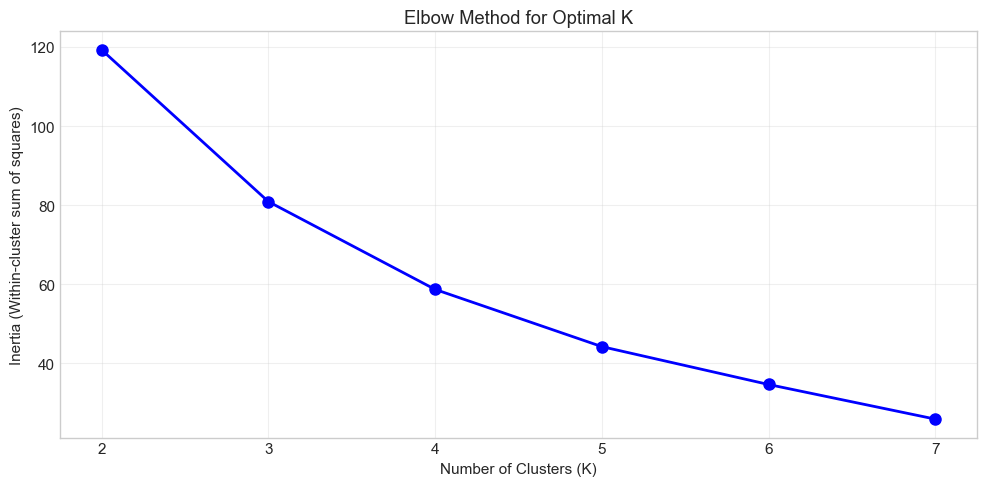

In [14]:
# Find optimal number of clusters using elbow method
inertias = []
K_range = range(2, min(8, len(commits)))

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax.set_xlabel("Number of Clusters (K)")
ax.set_ylabel("Inertia (Within-cluster sum of squares)")
ax.set_title("Elbow Method for Optimal K")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../outputs/ml1_elbow.png", dpi=150)
plt.show()

In [15]:
# Apply K-Means with chosen K
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
commits["cluster"] = kmeans.fit_predict(X_scaled)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.1%}")
print(f"\nCluster distribution:")
print(commits["cluster"].value_counts().sort_index())

PCA explained variance: 66.4%

Cluster distribution:
cluster
0    12
1     7
2     4
Name: count, dtype: int64


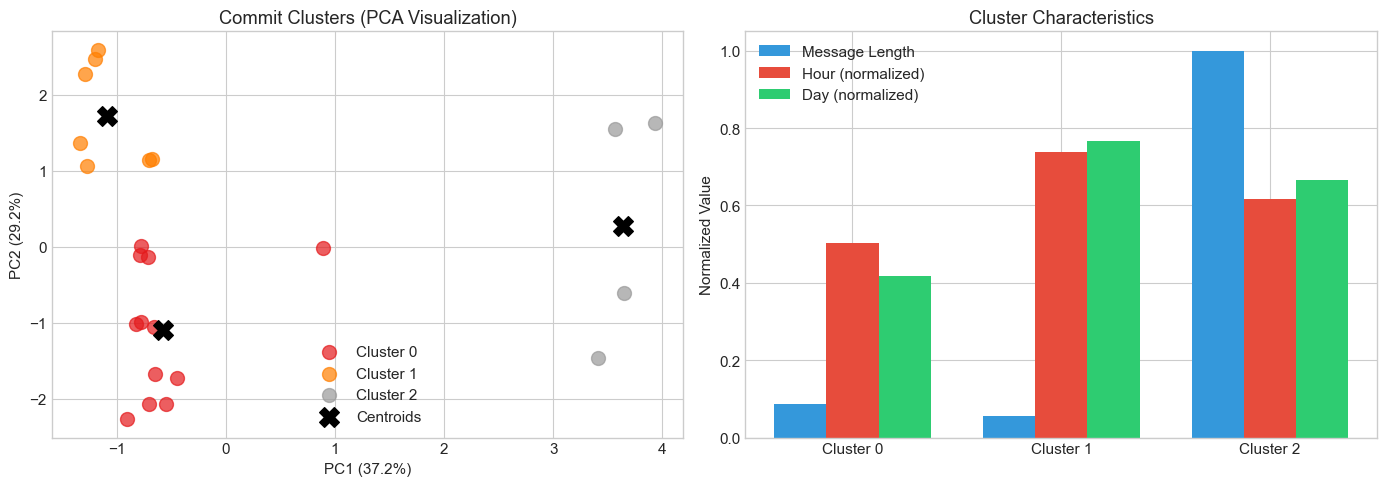

In [16]:
# Visualize clusters
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PCA scatter plot
colors = plt.cm.Set1(np.linspace(0, 1, optimal_k))
for cluster in range(optimal_k):
    mask = commits["cluster"] == cluster
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                    c=[colors[cluster]], label=f"Cluster {cluster}", alpha=0.7, s=100)

# Plot centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)
axes[0].scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
                c='black', marker='X', s=200, label='Centroids')

axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
axes[0].set_title("Commit Clusters (PCA Visualization)")
axes[0].legend()

# Cluster characteristics
cluster_stats = commits.groupby("cluster").agg({
    "msg_length": "mean",
    "hour": "mean",
    "day_of_week": "mean"
}).round(1)

x = np.arange(len(cluster_stats))
width = 0.25
axes[1].bar(x - width, cluster_stats["msg_length"] / cluster_stats["msg_length"].max(), 
            width, label='Message Length', color='#3498db')
axes[1].bar(x, cluster_stats["hour"] / 24, width, label='Hour (normalized)', color='#e74c3c')
axes[1].bar(x + width, cluster_stats["day_of_week"] / 6, width, label='Day (normalized)', color='#2ecc71')

axes[1].set_xticks(x)
axes[1].set_xticklabels([f"Cluster {i}" for i in range(optimal_k)])
axes[1].set_ylabel("Normalized Value")
axes[1].set_title("Cluster Characteristics")
axes[1].legend()

plt.tight_layout()
plt.savefig("../outputs/ml1_clusters.png", dpi=150)
plt.show()

In [17]:
# Interpret clusters
print("CLUSTER INTERPRETATION")
print("="*60)

for cluster in range(optimal_k):
    cluster_commits = commits[commits["cluster"] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_commits)} commits):")
    print(f"  Avg message length: {cluster_commits['msg_length'].mean():.0f} chars")
    print(f"  Avg hour (Central Time): {cluster_commits['hour'].mean():.1f}")
    print(f"  Weekend commits: {(cluster_commits['day_of_week'] >= 5).sum()}")
    print(f"  Example messages:")
    for msg in cluster_commits["message"].head(2):
        print(f"    - {str(msg)[:60]}..." if len(str(msg)) > 60 else f"    - {msg}")

CLUSTER INTERPRETATION

Cluster 0 (12 commits):
  Avg message length: 29 chars
  Avg hour (Central Time): 12.1
  Weekend commits: 2
  Example messages:
    - Create 1772E
    - Create 1842C

Cluster 1 (7 commits):
  Avg message length: 19 chars
  Avg hour (Central Time): 17.7
  Weekend commits: 5
  Example messages:
    - Create 1738C
    - Create 1760F

Cluster 2 (4 commits):
  Avg message length: 330 chars
  Avg hour (Central Time): 14.8
  Weekend commits: 2
  Example messages:
    - fix: reject boolean operands for floor_div at schema level

...
    - fix: handle Boolean + Unknown(Float) supertype resolution

F...


### ML Technique 2: Time Series Analysis & Forecasting

Analyze commit activity patterns and forecast future activity.

In [18]:
# Create weekly time series
commits["week"] = commits["date"].dt.to_period('W')
weekly_commits = commits.groupby("week").size()

# Fill missing weeks with 0
if len(weekly_commits) > 1:
    all_weeks = pd.period_range(weekly_commits.index.min(), weekly_commits.index.max(), freq='W')
    weekly_commits = weekly_commits.reindex(all_weeks, fill_value=0)

print(f"Time series length: {len(weekly_commits)} weeks")
print(f"Mean weekly commits: {weekly_commits.mean():.2f}")
print(f"Std weekly commits: {weekly_commits.std():.2f}")

Time series length: 121 weeks
Mean weekly commits: 0.19
Std weekly commits: 0.93


/var/folders/0b/4q6tccn90zd2mrdvjhd77ydm0000gn/T/ipykernel_41989/300041457.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  commits["week"] = commits["date"].dt.to_period('W')


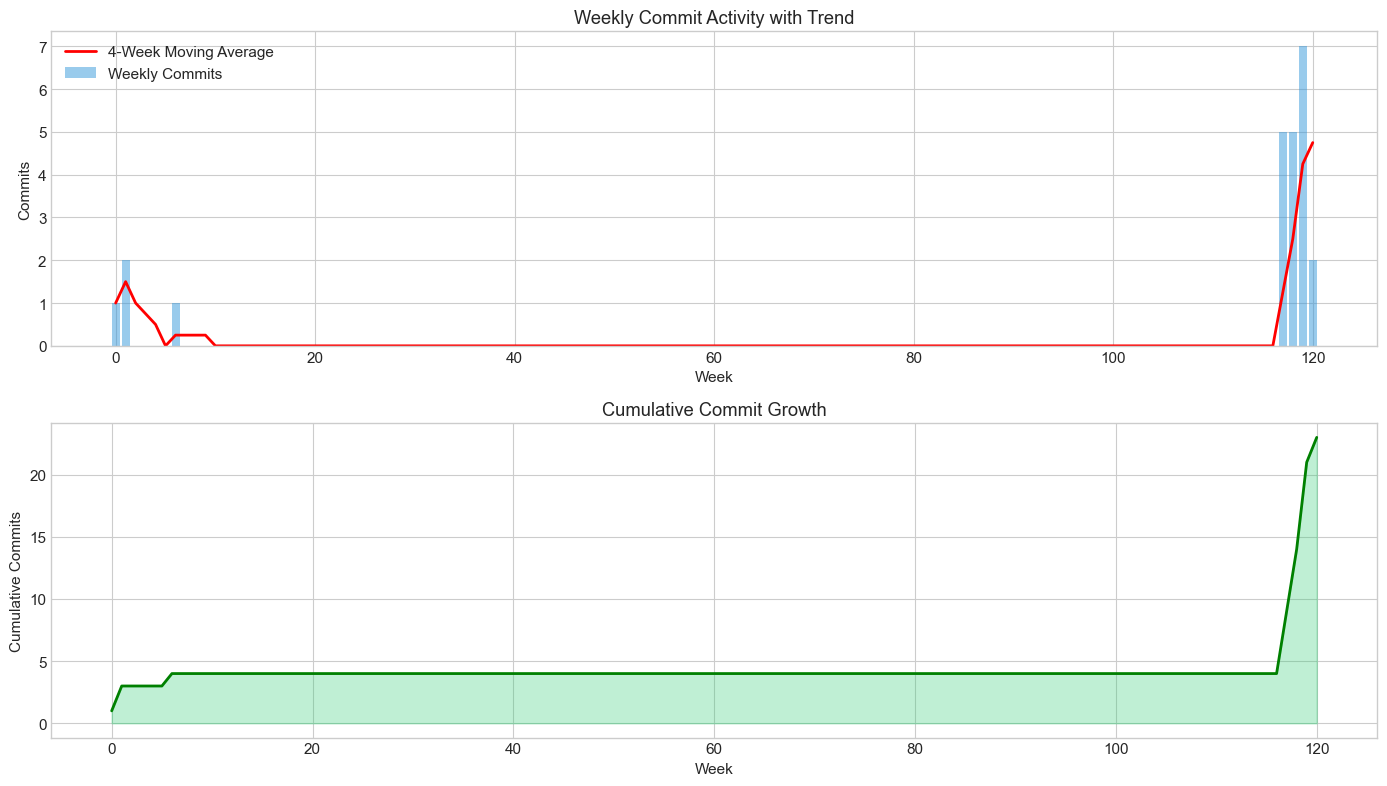

In [19]:
# Simple moving average analysis
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Raw data with moving average
x = range(len(weekly_commits))
axes[0].bar(x, weekly_commits.values, alpha=0.5, label='Weekly Commits', color='#3498db')

if len(weekly_commits) >= 4:
    ma_4 = weekly_commits.rolling(window=4, min_periods=1).mean()
    axes[0].plot(x, ma_4.values, 'r-', linewidth=2, label='4-Week Moving Average')

axes[0].set_xlabel("Week")
axes[0].set_ylabel("Commits")
axes[0].set_title("Weekly Commit Activity with Trend")
axes[0].legend()

# Cumulative commits
cumulative = weekly_commits.cumsum()
axes[1].fill_between(x, cumulative.values, alpha=0.3, color='#2ecc71')
axes[1].plot(x, cumulative.values, 'g-', linewidth=2)
axes[1].set_xlabel("Week")
axes[1].set_ylabel("Cumulative Commits")
axes[1].set_title("Cumulative Commit Growth")

plt.tight_layout()
plt.savefig("../outputs/ml2_timeseries.png", dpi=150)
plt.show()

In [20]:
# Simple linear regression forecast
from sklearn.linear_model import LinearRegression

X_time = np.arange(len(weekly_commits)).reshape(-1, 1)
y_commits = weekly_commits.values

model = LinearRegression()
model.fit(X_time, y_commits)

# Forecast next 8 weeks
forecast_weeks = 8
X_future = np.arange(len(weekly_commits), len(weekly_commits) + forecast_weeks).reshape(-1, 1)
y_forecast = model.predict(X_future)
y_forecast = np.maximum(y_forecast, 0)  # No negative commits

print(f"Linear Regression Model:")
print(f"  Slope (trend): {model.coef_[0]:.3f} commits/week")
print(f"  Intercept: {model.intercept_:.2f}")
print(f"  R² Score: {model.score(X_time, y_commits):.3f}")
print(f"\nForecast for next {forecast_weeks} weeks:")
print(f"  Predicted commits: {y_forecast.sum():.0f}")
print(f"  Avg per week: {y_forecast.mean():.1f}")

Linear Regression Model:
  Slope (trend): 0.006 commits/week
  Intercept: -0.17
  R² Score: 0.050

Forecast for next 8 weeks:
  Predicted commits: 5
  Avg per week: 0.6


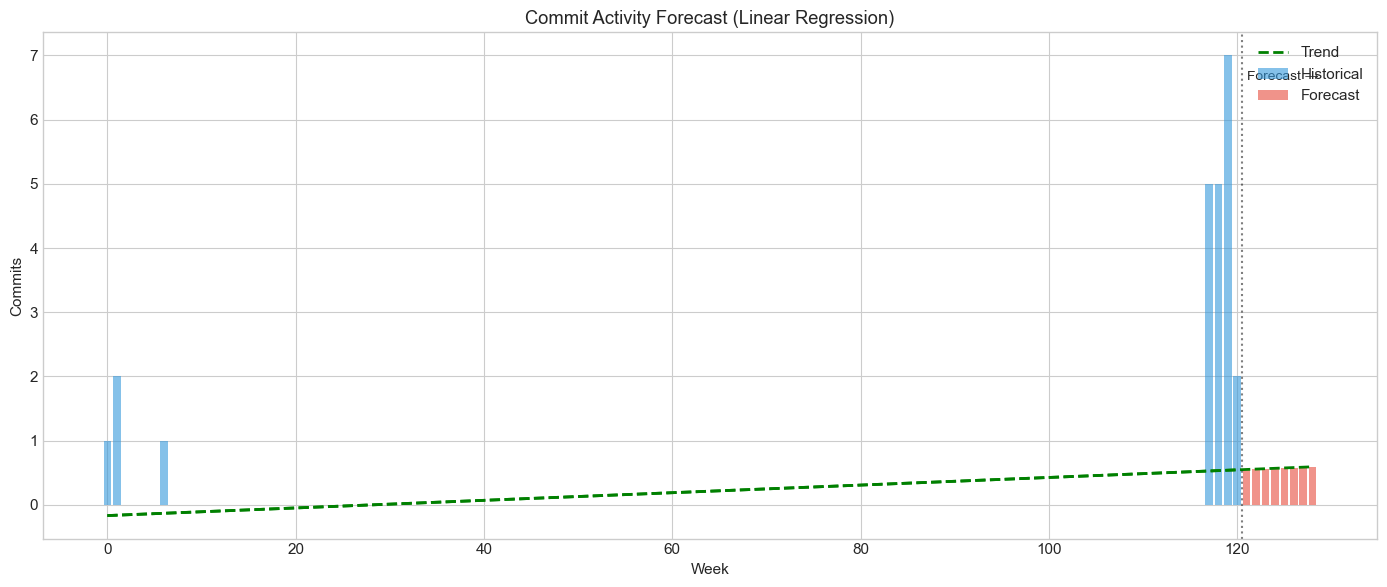

In [21]:
# Visualize forecast
fig, ax = plt.subplots(figsize=(14, 6))

# Historical data
x_hist = range(len(weekly_commits))
ax.bar(x_hist, weekly_commits.values, alpha=0.6, label='Historical', color='#3498db')

# Trend line
y_trend = model.predict(X_time)
ax.plot(x_hist, y_trend, 'g--', linewidth=2, label='Trend')

# Forecast
x_future = range(len(weekly_commits), len(weekly_commits) + forecast_weeks)
ax.bar(x_future, y_forecast, alpha=0.6, label='Forecast', color='#e74c3c')

# Extend trend line
x_all = np.arange(len(weekly_commits) + forecast_weeks).reshape(-1, 1)
y_all = model.predict(x_all)
ax.plot(range(len(y_all)), y_all, 'g--', linewidth=2)

# Vertical line separating historical and forecast
ax.axvline(x=len(weekly_commits) - 0.5, color='black', linestyle=':', alpha=0.5)
ax.text(len(weekly_commits), ax.get_ylim()[1] * 0.9, 'Forecast →', fontsize=10)

ax.set_xlabel("Week")
ax.set_ylabel("Commits")
ax.set_title("Commit Activity Forecast (Linear Regression)")
ax.legend()

plt.tight_layout()
plt.savefig("../outputs/ml2_forecast.png", dpi=150)
plt.show()

---
## Summary: Key Findings

In [22]:
print("="*70)
print("TRADITIONAL DATA SCIENCE ANALYSIS - KEY FINDINGS")
print("="*70)

print("\n1. ACTIVITY STATISTICS:")
print(f"   Total commits: {len(commits)}")
print(f"   Total repositories: {len(repos)}")
print(f"   Most active day: {day_names[commits['day_of_week'].mode().iloc[0]]}")
print(f"   Most active hour: {commits['hour'].mode().iloc[0]}:00 Central Time")

print("\n2. LANGUAGE PROFILE:")
top_lang = lang_totals.idxmax()
print(f"   Primary language: {top_lang} ({lang_totals[top_lang]/total_bytes*100:.1f}%)")
print(f"   Total languages: {len(lang_totals)}")

print("\n3. COMMIT PATTERNS:")
print(f"   Avg message length: {commits['msg_length'].mean():.0f} characters")
print(f"   Avg word count: {commits['word_count'].mean():.1f} words")

print("\n4. ML INSIGHTS:")
print(f"   Identified {optimal_k} commit clusters")
print(f"   Activity trend: {model.coef_[0]:.3f} commits/week {'(increasing)' if model.coef_[0] > 0 else '(decreasing)'}")
print(f"   Forecast (next 8 weeks): ~{y_forecast.sum():.0f} commits")

print("\n5. VISUALIZATIONS GENERATED:")
viz_files = list(OUT.glob("viz*.png")) + list(OUT.glob("ml*.png"))
for f in sorted(viz_files):
    print(f"   - {f.name}")

TRADITIONAL DATA SCIENCE ANALYSIS - KEY FINDINGS

1. ACTIVITY STATISTICS:
   Total commits: 23
   Total repositories: 7
   Most active day: Tuesday
   Most active hour: 16:00 Central Time

2. LANGUAGE PROFILE:
   Primary language: Rust (62.6%)
   Total languages: 9

3. COMMIT PATTERNS:
   Avg message length: 78 characters
   Avg word count: 10.9 words

4. ML INSIGHTS:
   Identified 3 commit clusters
   Activity trend: 0.006 commits/week (increasing)
   Forecast (next 8 weeks): ~5 commits

5. VISUALIZATIONS GENERATED:
   - ml1_clusters.png
   - ml1_elbow.png
   - ml2_forecast.png
   - ml2_timeseries.png
   - viz1_commit_timeline.png
   - viz2_languages.png
   - viz3_activity_heatmap.png
   - viz4_repo_comparison.png
   - viz5_message_analysis.png
   - viz6_contribution_timeline.png
